# Imports

In [1]:
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Config

In [3]:
user_classes = ["sustainers", "burnouts", "churnouts"]

In [ ]:
train_path = "../data/chunk_1.npy"
test_path = "../data/chunk_2.npy"

In [4]:
non_feature_cols = list(map(str, [*range(1,5)]))
no_change_cols = list(map(str, [*range(5,9)]))
standardization_cols = list(map(str, [*range(9,19)]))
normalization_cols = list(map(str, [*range(19,31)]))
binary_cols = list(map(str, [*range(31,40)]))

float_cols = [*no_change_cols, *standardization_cols, *normalization_cols, *binary_cols]
all_cols = [*float_cols, *non_feature_cols]

# Loading and preprocessing data

In [5]:
class_mapping = {"sustainers": 0, "burnouts": 1, "churnouts": 2}

#### Train Data

In [6]:
data_train = np.load(train_path, allow_pickle=True)

data_train = data_train[:, :100, :]
data_train = data_train.reshape(-1, 42)
data_train = data_train[~np.all(data_train == 0, axis=1)]

df_train = pd.DataFrame(data_train, columns=[*all_cols, "class", "user_id", "settlement_part_id"])
del data_train

for col in float_cols:
    df_train.loc[:, col] = df_train.loc[:, col].astype(float)

y_train = df_train.groupby("user_id").agg({"class": "unique"})
y_train.loc[:, "class"] = y_train.loc[:, "class"].apply(lambda x: class_mapping[x[0]])
y_train = y_train.to_numpy()

X_train = df_train.groupby("user_id").agg(dict(zip(float_cols, ["mean"]*len(float_cols)))).to_numpy()
del df_train

#### Test Data

In [7]:
data_test = np.load("../data/chunk_2.npy", allow_pickle=True)

data_test = data_test[:, :100, :]
data_test = data_test.reshape(-1, 42)
data_test = data_test[~np.all(data_test == 0, axis=1)]

df_test = pd.DataFrame(data_test, columns=[*all_cols, "class", "user_id", "settlement_part_id"])
del data_test

for col in float_cols:
    df_test.loc[:, col] = df_test.loc[:, col].astype(float)

y_test = df_test.groupby("user_id").agg({"class": "unique"})
y_test.loc[:, "class"] = y_test.loc[:, "class"].apply(lambda x: class_mapping[x[0]])
y_test = y_test.to_numpy()

X_test = df_test.groupby("user_id").agg(dict(zip(float_cols, ["mean"]*len(float_cols)))).to_numpy()
del df_test

In [8]:
y_train, y_test = y_train.flatten(), y_test.flatten()

# Modeling

In [9]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.metrics import classification_report

In [10]:
target_names = ["sustainers", "burnouts", "churnouts"]

### Logistic Regression

In [11]:
clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(X_train, y_train)

print("Train Classification Report")
print("--------------------------")
print(classification_report(y_train, clf.predict(X_train), target_names=target_names))

print("\n")

print("Test Classification Report")
print("--------------------------")
print(classification_report(y_test, clf.predict(X_test), target_names=target_names))

Train Classification Report
--------------------------
              precision    recall  f1-score   support

  sustainers       0.64      0.23      0.34       115
    burnouts       0.62      0.06      0.12        78
   churnouts       0.60      0.94      0.73       256

    accuracy                           0.61       449
   macro avg       0.62      0.41      0.40       449
weighted avg       0.62      0.61      0.53       449



Test Classification Report
--------------------------
              precision    recall  f1-score   support

  sustainers       0.41      0.15      0.22       115
    burnouts       0.60      0.04      0.07        77
   churnouts       0.59      0.92      0.72       256

    accuracy                           0.57       448
   macro avg       0.53      0.37      0.34       448
weighted avg       0.55      0.57      0.48       448



### Random Forest

In [12]:
clf = RandomForestClassifier(max_depth=None, min_samples_leaf=1, random_state=0)
clf.fit(X_train, y_train)

print("Train Classification Report")
print("--------------------------")
print(classification_report(y_train, clf.predict(X_train), target_names=target_names))

print("\n")

print("Test Classification Report")
print("--------------------------")
print(classification_report(y_test, clf.predict(X_test), target_names=target_names))

Train Classification Report
--------------------------
              precision    recall  f1-score   support

  sustainers       1.00      1.00      1.00       115
    burnouts       1.00      1.00      1.00        78
   churnouts       1.00      1.00      1.00       256

    accuracy                           1.00       449
   macro avg       1.00      1.00      1.00       449
weighted avg       1.00      1.00      1.00       449



Test Classification Report
--------------------------
              precision    recall  f1-score   support

  sustainers       0.39      0.18      0.25       115
    burnouts       0.57      0.10      0.18        77
   churnouts       0.60      0.89      0.71       256

    accuracy                           0.57       448
   macro avg       0.52      0.39      0.38       448
weighted avg       0.54      0.57      0.50       448



### SVM

In [13]:
clf = SVC(C=100, random_state=0)
clf.fit(X_train, y_train)

print("Train Classification Report")
print("--------------------------")
print(classification_report(y_train, clf.predict(X_train), target_names=target_names))

print("\n")

print("Test Classification Report")
print("--------------------------")
print(classification_report(y_test, clf.predict(X_test), target_names=target_names))

Train Classification Report
--------------------------
              precision    recall  f1-score   support

  sustainers       0.78      0.60      0.68       115
    burnouts       0.94      0.38      0.55        78
   churnouts       0.72      0.93      0.81       256

    accuracy                           0.75       449
   macro avg       0.81      0.64      0.68       449
weighted avg       0.78      0.75      0.73       449



Test Classification Report
--------------------------
              precision    recall  f1-score   support

  sustainers       0.37      0.23      0.28       115
    burnouts       0.35      0.10      0.16        77
   churnouts       0.61      0.84      0.71       256

    accuracy                           0.56       448
   macro avg       0.44      0.39      0.38       448
weighted avg       0.50      0.56      0.50       448



### XGBoost

In [14]:
clf = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", n_estimators=10, max_depth=1, random_state=0)
clf.fit(X_train, y_train)

print("Train Classification Report")
print("--------------------------")
print(classification_report(y_train, clf.predict(X_train), target_names=target_names))

print("\n")

print("Test Classification Report")
print("--------------------------")
print(classification_report(y_test, clf.predict(X_test), target_names=target_names))

Train Classification Report
--------------------------
              precision    recall  f1-score   support

  sustainers       0.76      0.17      0.27       115
    burnouts       1.00      0.05      0.10        78
   churnouts       0.60      0.98      0.74       256

    accuracy                           0.61       449
   macro avg       0.79      0.40      0.37       449
weighted avg       0.71      0.61      0.51       449



Test Classification Report
--------------------------
              precision    recall  f1-score   support

  sustainers       0.33      0.05      0.09       115
    burnouts       0.50      0.03      0.05        77
   churnouts       0.58      0.96      0.72       256

    accuracy                           0.57       448
   macro avg       0.47      0.35      0.29       448
weighted avg       0.50      0.57      0.44       448



### ANN

In [15]:
clf = MLPClassifier(random_state=0, max_iter=1000, hidden_layer_sizes=(10,))
clf.fit(X_train, y_train)

print("Train Classification Report")
print("--------------------------")
print(classification_report(y_train, clf.predict(X_train), target_names=target_names))

print("\n")

print("Test Classification Report")
print("--------------------------")
print(classification_report(y_test, clf.predict(X_test), target_names=target_names))

Train Classification Report
--------------------------
              precision    recall  f1-score   support

  sustainers       0.66      0.35      0.45       115
    burnouts       0.58      0.14      0.23        78
   churnouts       0.62      0.89      0.73       256

    accuracy                           0.62       449
   macro avg       0.62      0.46      0.47       449
weighted avg       0.62      0.62      0.57       449



Test Classification Report
--------------------------
              precision    recall  f1-score   support

  sustainers       0.38      0.17      0.23       115
    burnouts       0.40      0.05      0.09        77
   churnouts       0.59      0.89      0.71       256

    accuracy                           0.56       448
   macro avg       0.46      0.37      0.34       448
weighted avg       0.50      0.56      0.48       448



# Explaining RandomForest model with SHAP

In [16]:
import shap

In [17]:
clf = RandomForestClassifier(max_depth=None, min_samples_leaf=1, random_state=0)
clf.fit(X_train, y_train)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

### SHAP Feature importance

In [18]:
plot_cols = ['5','6','8','12','13','14','16','17','18','23','24','25','26','27','28','31','35','37','39']

plot_cols_names = [
    "Performance in Rumble",
    "Drop Probability",
    "Drop Adherence",
    "Cash Amount Won",
    "Entry Fee",
    "Player's Net Gain",
    "Money Withdrawn Before Game",
    "Money Added Before Game",
    "Time Since Last Game",
    "Current Game's Time",
    "Game Finished Normally",
    "Hand Dropped Before Game Start",
    "Hand Dropped After Game Start",
    "Wrong Finish",
    "Continuous Missed Moves",
    "Rummy Type Switched",
    "Win Status",
    "Rumble Indicator",
    "Table Size",
]

In [19]:
plot_cols_idx = [float_cols.index(i) for i in plot_cols]
shap_new = [i[:, plot_cols_idx] for i in shap_values]

In [20]:
plt.rcParams.update({"font.size": 20})

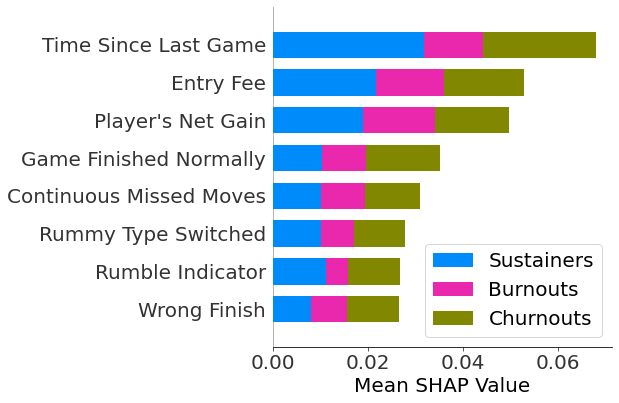

In [21]:
_ = shap.summary_plot(
    shap_new, 
    X_train[:, plot_cols_idx], 
    feature_names=plot_cols_names, 
    plot_type="bar", 
    class_inds=[0,1,2],
    class_names=["Sustainers", "Burnouts", "Churnouts"],
    plot_size=(9,6),
    max_display=8, 
    show=False,
)
_ = plt.xticks([0.00, 0.02, 0.04, 0.06], size=20)
_ = plt.yticks(size=20)
_ = plt.xlabel("Mean SHAP Value", size=20)
_ = plt.legend(prop={'size': 20})
_ = plt.tight_layout()
# _ = plt.savefig("../clusters/individual_analysis/img/SHAP.png")

The most influential variables to decide whether a player will sustain, burnout or churn are his patience(Time Since Last Game), willingness to bet(Entry Fee) and payoff the player receives(Player's Net Gain). The model finds it hard to raise accuracy beyond ~60% as the key variables it looks at are more related to the monetary attitude of the player, instead of the gameplay specific variables like drop adherence, etc.